In [8]:
from pathlib import Path

import eelbrain
from matplotlib import pyplot
from matplotlib.patches import ConnectionPatch
import mne


# Data locations
DATA_ROOT = Path("~").expanduser() / 'Data' / 'cocoha'
STIMULUS_DIR = DATA_ROOT / 'stimuli'
PREDICTOR_DIR = DATA_ROOT / 'predictors'
TRF_DIR = DATA_ROOT / 'TRFs'


# Where to save the figure
DST = DATA_ROOT / 'figures'
DST.mkdir(exist_ok=True)

# Configure the matplotlib figure style
FONT = 'Arial'
FONT_SIZE = 8
RC = {
    'figure.dpi': 100,
    'savefig.dpi': 300,
    'savefig.transparent': True,
    # Font
    'font.family': 'sans-serif',
    'font.sans-serif': FONT,
    'font.size': FONT_SIZE,
    'figure.labelsize': FONT_SIZE,
    'figure.titlesize': FONT_SIZE,
    'axes.labelsize': FONT_SIZE,
    'axes.titlesize': FONT_SIZE,
    'xtick.labelsize': FONT_SIZE,
    'ytick.labelsize': FONT_SIZE,    
    'legend.fontsize': FONT_SIZE,
}
pyplot.rcParams.update(RC)

In [9]:
import re

# Get all subjects
SUBJECTS = [path.name for path in TRF_DIR.iterdir() if re.match(r'S\d+_data_preproc', path.name)]
SUBJECTS = sorted(SUBJECTS, key=lambda x: int(re.search(r'S(\d+)', x).group(1)))

print(f"Found {len(SUBJECTS)} subjects")
print(SUBJECTS)

Found 18 subjects
['S1_data_preproc', 'S2_data_preproc', 'S3_data_preproc', 'S4_data_preproc', 'S5_data_preproc', 'S6_data_preproc', 'S7_data_preproc', 'S8_data_preproc', 'S9_data_preproc', 'S10_data_preproc', 'S11_data_preproc', 'S12_data_preproc', 'S13_data_preproc', 'S14_data_preproc', 'S15_data_preproc', 'S16_data_preproc', 'S17_data_preproc', 'S18_data_preproc']


In [23]:
# Load envelope TRFs for all subjects
trfs = []
r_values = []

for subject in SUBJECTS:
    trf_path = TRF_DIR / subject / f'{subject} envelope.pickle'
    if trf_path.exists():
        trf = eelbrain.load.unpickle(trf_path)
        trfs.append(trf)
        r_values.append(trf.r)  # Cross-validated correlation
        print(f"Loaded {subject}: mean r = {trf.r.mean():.4f}")
    else:
        print(f"Missing: {trf_path}")

print(f"\nTotal TRFs loaded: {len(trfs)}")

Loaded S1_data_preproc: mean r = 0.0269
Loaded S2_data_preproc: mean r = 0.0042
Loaded S3_data_preproc: mean r = -0.0010
Loaded S4_data_preproc: mean r = -0.0013
Loaded S5_data_preproc: mean r = 0.0036
Loaded S6_data_preproc: mean r = -0.0065
Loaded S7_data_preproc: mean r = 0.0011
Loaded S8_data_preproc: mean r = 0.0024
Loaded S9_data_preproc: mean r = -0.0008
Loaded S10_data_preproc: mean r = 0.0060
Loaded S11_data_preproc: mean r = -0.0199
Loaded S12_data_preproc: mean r = -0.0024
Loaded S13_data_preproc: mean r = 0.0069
Loaded S14_data_preproc: mean r = 0.0231
Loaded S15_data_preproc: mean r = 0.0096
Loaded S16_data_preproc: mean r = 0.0035
Loaded S17_data_preproc: mean r = -0.0065
Loaded S18_data_preproc: mean r = 0.0020

Total TRFs loaded: 18


'" \nfor i in range(len(trfs)):\n    # plot all the means of trfs in one plot\n    trf_mean = trfs[i].h_scaled[0].mean(\'sensor\')\n    plot = eelbrain.plot.UTS(trf_mean, title=f\'Subject {SUBJECTS[i]} - Mean TRF across sensors\')\n\n'

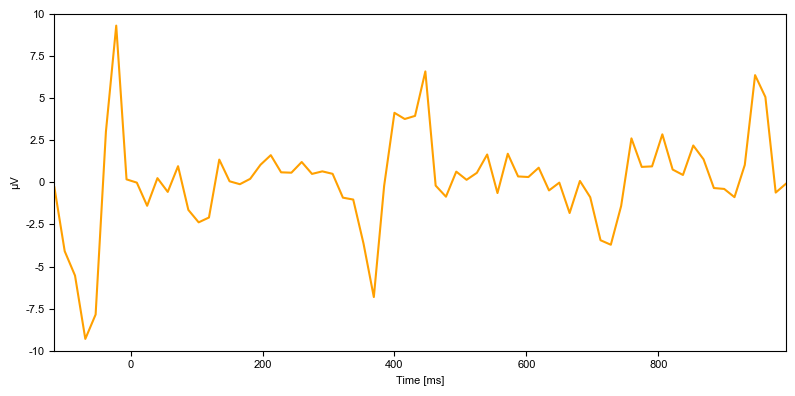

In [41]:
trf_0_mean = trfs[2].h_scaled[0].mean('sensor')
plot2 = eelbrain.plot.UTS(trf_0_mean)

"""" 
for i in range(len(trfs)):
    # plot all the means of trfs in one plot
    trf_mean = trfs[i].h_scaled[0].mean('sensor')
    plot = eelbrain.plot.UTS(trf_mean, title=f'Subject {SUBJECTS[i]} - Mean TRF across sensors')

"""

/Users/sylvestereley/miniforge3/envs/eelbrain/lib/python3.13/site-packages/eelbrain/plot/_base.py:1741: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  self.figure.tight_layout()


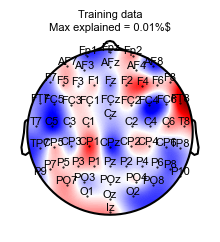

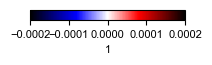

In [18]:
titles = [f'Training data\nMax explained = {trf.proportion_explained.max():.2%}$']
p = eelbrain.plot.Topomap(trf.proportion_explained, sensorlabels='name', clip='circle', rows=1, axtitle=titles)
p_cb = p.plot_colorbar(width=.1, w=2)

/var/folders/q5/dlf_55750jq9b22jkpyf6c940000gn/T/ipykernel_44646/1160176440.py:26: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  pyplot.tight_layout()


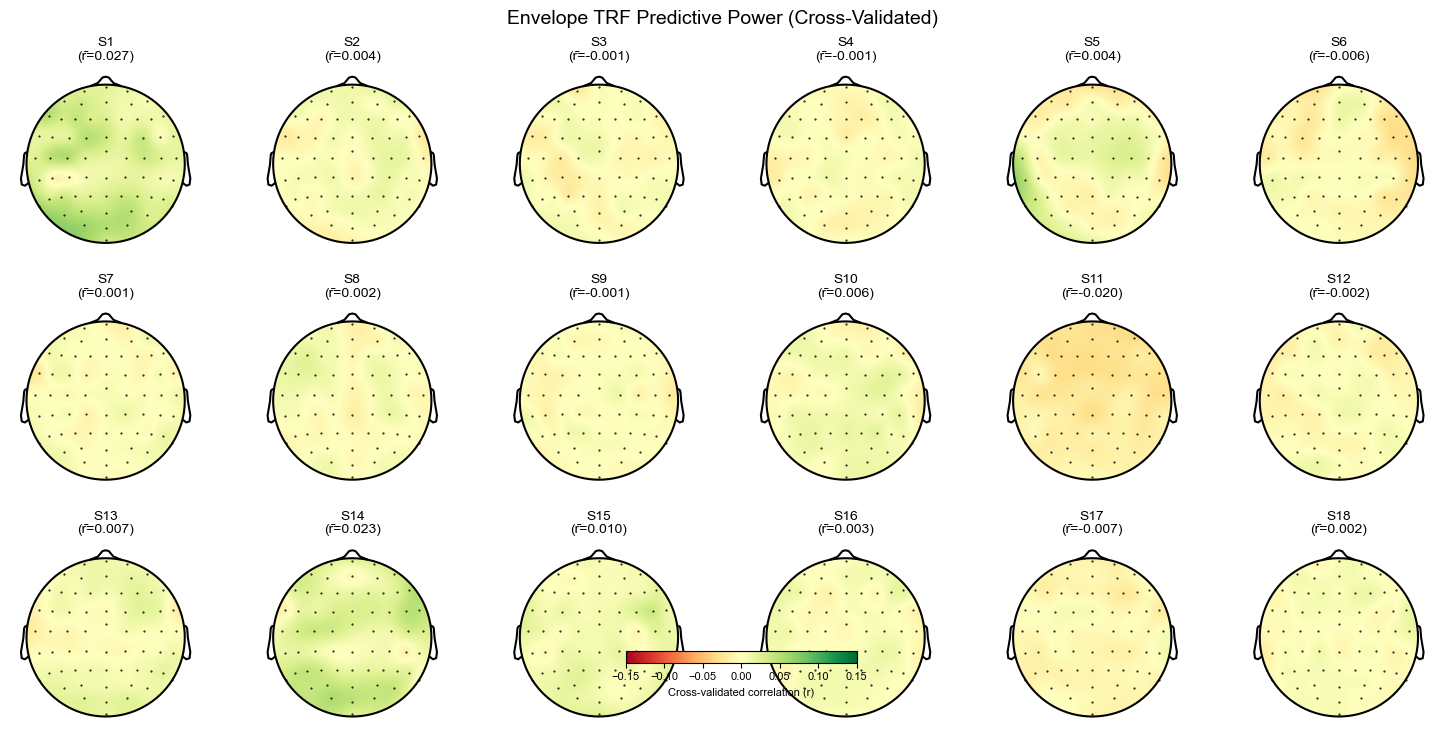

In [12]:
# Create a grid of topomaps showing cross-validated correlations for all subjects
fig, axes = pyplot.subplots(3, 6, figsize=(15, 7.5))
axes = axes.flatten()

for idx, (subject, r) in enumerate(zip(SUBJECTS[:len(r_values)], r_values)):
    ax = axes[idx]
    subject_num = re.search(r'S(\d+)', subject).group(1)
    
    # Plot topomap with sensor values
    p = eelbrain.plot.Topomap(r, clip='circle', axes=ax, show=False, 
                              vmax=0.15, cmap='RdYlGn', contours=False)
    
    # Add sensor labels with correlation values
    ax.set_title(f'S{subject_num}\n(r̄={r.mean():.3f})', fontsize=10)

# Hide unused subplots
for idx in range(len(r_values), len(axes)):
    axes[idx].axis('off')

# Add colorbar - get mappable from any plotted axis
mappable = axes[0].images[0] if axes[0].images else axes[0].collections[0]
fig.colorbar(mappable, ax=axes, orientation='horizontal', 
             fraction=0.02, pad=0.05, label='Cross-validated correlation (r)')

pyplot.suptitle('Envelope TRF Predictive Power (Cross-Validated)', fontsize=14, y=0.98)
pyplot.tight_layout()
pyplot.show()

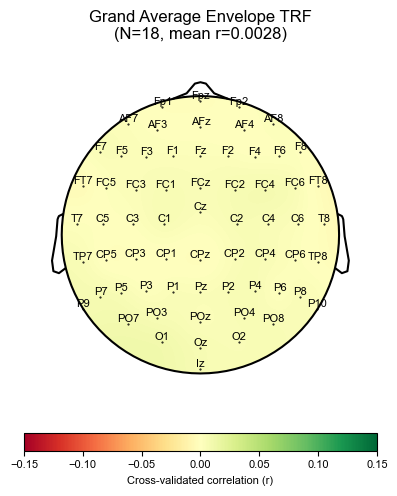

In [14]:
# Grand average topomap with sensor values displayed
grand_avg_r = sum(r_values) / len(r_values)

fig, ax = pyplot.subplots(1, 1, figsize=(6, 5))
p = eelbrain.plot.Topomap(grand_avg_r, clip='circle', axes=ax, show=False,
                          vmax=0.15, cmap='RdYlGn', contours=6, 
                          sensorlabels='name')

ax.set_title(f'Grand Average Envelope TRF\n(N={len(r_values)}, mean r={grand_avg_r.mean():.4f})', 
             fontsize=12, pad=20)

# Add colorbar - get mappable from axis
mappable = ax.images[0] if ax.images else ax.collections[0]
pyplot.colorbar(mappable, ax=ax, orientation='horizontal',
                fraction=0.046, pad=0.08, label='Cross-validated correlation (r)')

pyplot.tight_layout()
pyplot.show()

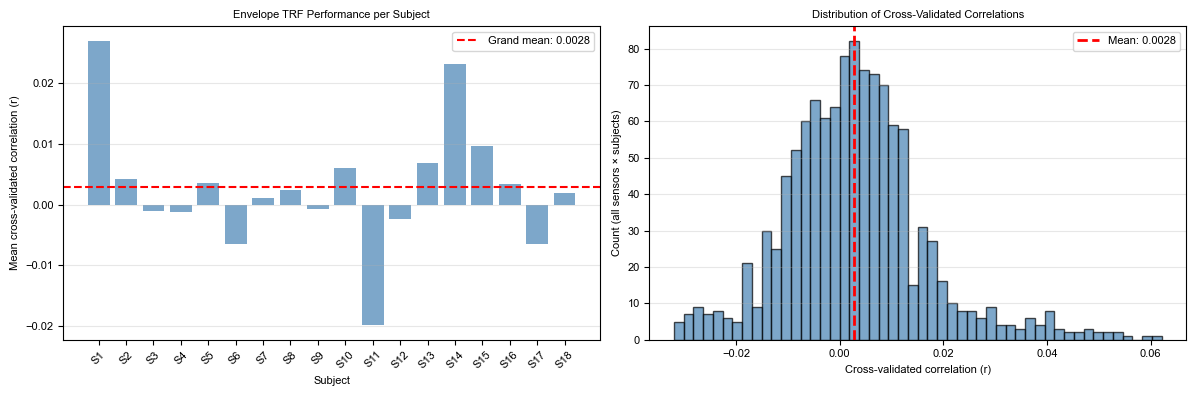


Summary Statistics:
Mean r across all sensors and subjects: 0.0028
Std: 0.0138
Min: -0.0320
Max: 0.0621


In [15]:
# Summary statistics across subjects
import numpy as np

mean_r_per_subject = [r.mean() for r in r_values]

fig, (ax1, ax2) = pyplot.subplots(1, 2, figsize=(12, 4))

# Bar plot of mean correlation per subject
x = np.arange(len(mean_r_per_subject))
ax1.bar(x, mean_r_per_subject, color='steelblue', alpha=0.7)
ax1.axhline(np.mean(mean_r_per_subject), color='red', linestyle='--', 
            label=f'Grand mean: {np.mean(mean_r_per_subject):.4f}')
ax1.set_xlabel('Subject')
ax1.set_ylabel('Mean cross-validated correlation (r)')
ax1.set_title('Envelope TRF Performance per Subject')
ax1.set_xticks(x)
ax1.set_xticklabels([f'S{i+1}' for i in range(len(mean_r_per_subject))], rotation=45)
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Histogram of correlation values
all_r_values = np.concatenate([r.x.flatten() for r in r_values])
ax2.hist(all_r_values, bins=50, color='steelblue', alpha=0.7, edgecolor='black')
ax2.axvline(all_r_values.mean(), color='red', linestyle='--', linewidth=2,
            label=f'Mean: {all_r_values.mean():.4f}')
ax2.set_xlabel('Cross-validated correlation (r)')
ax2.set_ylabel('Count (all sensors × subjects)')
ax2.set_title('Distribution of Cross-Validated Correlations')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

pyplot.tight_layout()
pyplot.show()

print(f"\nSummary Statistics:")
print(f"Mean r across all sensors and subjects: {all_r_values.mean():.4f}")
print(f"Std: {all_r_values.std():.4f}")
print(f"Min: {all_r_values.min():.4f}")
print(f"Max: {all_r_values.max():.4f}")

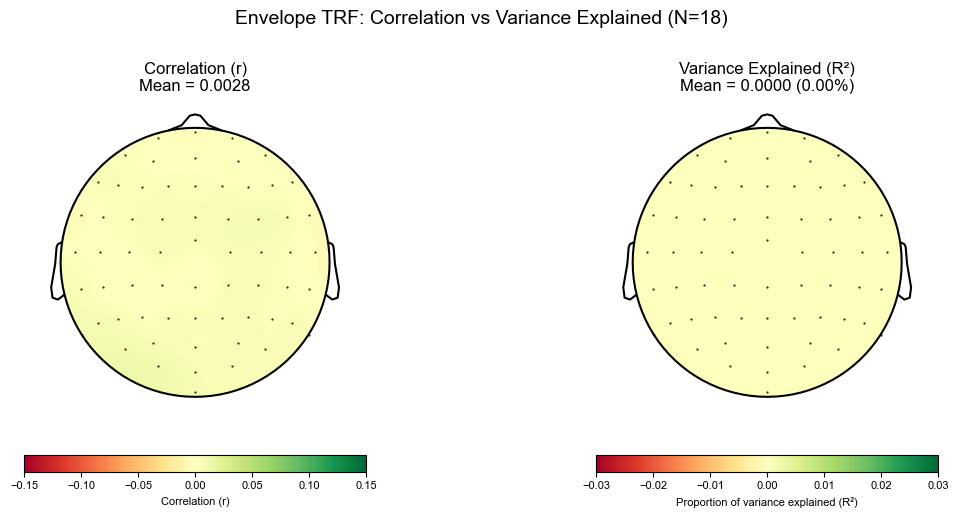


Grand Average Statistics:
Correlation (r): 0.0028
Variance Explained (R²): 0.0000 (0.00%)

Per-subject mean variance explained:
  S1: 0.0010 (0.10%)
  S2: 0.0001 (0.01%)
  S3: 0.0001 (0.01%)
  S4: 0.0000 (0.00%)
  S5: 0.0002 (0.02%)
  S6: 0.0002 (0.02%)
  S7: 0.0000 (0.00%)
  S8: 0.0001 (0.01%)
  S9: 0.0000 (0.00%)
  S10: 0.0001 (0.01%)
  S11: 0.0005 (0.05%)
  S12: 0.0001 (0.01%)
  S13: 0.0001 (0.01%)
  S14: 0.0007 (0.07%)
  S15: 0.0002 (0.02%)
  S16: 0.0001 (0.01%)
  S17: 0.0001 (0.01%)
  S18: 0.0000 (0.00%)


In [16]:
# Variance explained (R²) - proportion of variance explained
r2_values = [r ** 2 for r in r_values]
grand_avg_r2 = grand_avg_r ** 2

# Create side-by-side comparison of correlation (r) and variance explained (R²)
fig, (ax1, ax2) = pyplot.subplots(1, 2, figsize=(12, 5))

# Left: Correlation (r)
p1 = eelbrain.plot.Topomap(grand_avg_r, clip='circle', axes=ax1, show=False,
                           vmax=0.15, cmap='RdYlGn', contours=6)
ax1.set_title(f'Correlation (r)\nMean = {grand_avg_r.mean():.4f}', fontsize=12)
mappable1 = ax1.images[0] if ax1.images else ax1.collections[0]
pyplot.colorbar(mappable1, ax=ax1, orientation='horizontal',
                fraction=0.046, pad=0.08, label='Correlation (r)')

# Right: Variance explained (R²)
p2 = eelbrain.plot.Topomap(grand_avg_r2, clip='circle', axes=ax2, show=False,
                           vmax=0.03, cmap='RdYlGn', contours=6)
ax2.set_title(f'Variance Explained (R²)\nMean = {grand_avg_r2.mean():.4f} ({grand_avg_r2.mean()*100:.2f}%)', 
              fontsize=12)
mappable2 = ax2.images[0] if ax2.images else ax2.collections[0]
pyplot.colorbar(mappable2, ax=ax2, orientation='horizontal',
                fraction=0.046, pad=0.08, label='Proportion of variance explained (R²)')

pyplot.suptitle(f'Envelope TRF: Correlation vs Variance Explained (N={len(r_values)})', 
                fontsize=14, y=1.02)
pyplot.tight_layout()
pyplot.show()

# Print statistics
print(f"\nGrand Average Statistics:")
print(f"Correlation (r): {grand_avg_r.mean():.4f}")
print(f"Variance Explained (R²): {grand_avg_r2.mean():.4f} ({grand_avg_r2.mean()*100:.2f}%)")
print(f"\nPer-subject mean variance explained:")
for i, r2 in enumerate(r2_values):
    print(f"  S{i+1}: {r2.mean():.4f} ({r2.mean()*100:.2f}%)")